# Mechanistic Anomaly detection methods on the "tiny natural mechanisms" task
## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from copy import deepcopy

import blobfile as bf
import torch
from cupbearer import data, detectors, models, scripts, tasks, utils
from IPython.display import Markdown, display
from torch import nn
from torch.utils.data import Subset
from transformer_lens import HookedTransformer
from functools import partial
import numpy as np
import umap
import umap.plot
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f'device = {device}')

/home/jordan/miniconda3/envs/MAD/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jordan/miniconda3/envs/MAD/lib/python3.10/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/home/jordan/miniconda3/envs/MAD/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/jordan/miniconda3/envs/MAD/lib/python3.1

device = cuda


In [3]:
def get_activation_at_last_token(
    activation: torch.Tensor, *args,
):
    if activation.ndim == 3:
        # Residual stream or equivalent, shape is (batch, seq, hidden)
        return activation[:, -1, :]
    elif activation.ndim == 4 and activation.shape[-1] == activation.shape[-2]:
        # Attention, shape is (batch, num_heads, query, key)
        # TODO: this could also be Q/K/V if n_heads happens to be head_dim
        return activation[:, :, -1, :].reshape(activation.shape[0], -1)
    elif activation.ndim == 4:
        # Query/key/value, shape is (batch, seq, num_heads, hidden)
        return activation[:, -1, :, :].reshape(activation.shape[0], -1)
    else:
        raise ValueError(f"Unexpected activation shape: {activation.shape}")

# Load the tiny natural mechanisms task & model

In [4]:
task = tasks.tiny_natural_mechanisms("ifelse", device)
task.model.to(device)
for name, _ in task.model.named_modules():
    print(name)

names = [
    # "hook_embed.output",
    # "blocks.0.hook_resid_pre.output",
    # "blocks.0.attn.hook_attn_scores.output",
    # "blocks.0.attn.hook_q.output",            
    # "blocks.0.attn.hook_k.output",
    # "blocks.0.attn.hook_v.output",
    # "blocks.0.attn.hook_z.input",             # GOOD
    # "blocks.0.attn.hook_z.output",            # GOOD
    # "blocks.0.hook_attn_out.output",          # GOOD
    # "blocks.0.hook_mlp_in",
    "blocks.0.hook_resid_post.output",        # GOOD
    # "ln_final.hook_normalized.output",
    # "unembed.input",
]

/home/jordan/miniconda3/envs/MAD/lib/python3.10/site-packages/transformer_lens/utils.py:62: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file_path, map_lo

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  cuda


/mnt/c/Users/nadro/Documents/AI_safety/CHAI/MAD_code/cupbearer/src/cupbearer/tasks/tiny_natural_mechanisms.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict =

Moving model to device:  cuda

embed
hook_embed
pos_embed
hook_pos_embed
blocks
blocks.0
blocks.0.ln1
blocks.0.ln1.hook_scale
blocks.0.ln1.hook_normalized
blocks.0.attn
blocks.0.attn.hook_k
blocks.0.attn.hook_q
blocks.0.attn.hook_v
blocks.0.attn.hook_z
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_pattern
blocks.0.attn.hook_result
blocks.0.hook_attn_in
blocks.0.hook_q_input
blocks.0.hook_k_input
blocks.0.hook_v_input
blocks.0.hook_mlp_in
blocks.0.hook_attn_out
blocks.0.hook_mlp_out
blocks.0.hook_resid_pre
blocks.0.hook_resid_post
ln_final
ln_final.hook_scale
ln_final.hook_normalized
unembed


In [5]:
# Visualize examples in the the test dataset
def sample_format_fn(sample):
    prompt = ''.join(task.model.tokenizer.convert_ids_to_tokens(sample[0])).replace('Ġ',' ')
    completion = ''.join(task.model.tokenizer.convert_ids_to_tokens([sample[1]])).replace('Ġ',' ')
    return f"|{prompt}| -> |{completion}|"

for anomalous in [False, True]:
    print('\n----------------------------------------------------------------------')
    print(f"-------------------------{' ANOMALOUS EXAMPLES ' if anomalous else ' NORMAL EXAMPLES ---'}-------------------------")
    print('----------------------------------------------------------------------')
    for i in range(50):
        sample = task.test_data.anomalous_data[i] if anomalous else task.test_data.normal_data[i]
        print(f"{'ANOMALY: ' if anomalous else 'NORMAL:  '}{sample_format_fn(sample)}")


----------------------------------------------------------------------
------------------------- NORMAL EXAMPLES ----------------------------
----------------------------------------------------------------------
NORMAL:  |with_fallback(self):Ċ        return self.name if self.name| -> | else|
NORMAL:  | = True if event.type is pygame.MOUSEBUTTONDOWN| -> | else|
NORMAL:  | [(a + (p / float(t))) / 2.0 if t| -> | else|
NORMAL:  |):Ċ        addr_list = self.change_addresses if for_change| -> | else|
NORMAL:  | // comm_size + \Ċ        1 if o.start_iter > 0| -> | else|
NORMAL:  |line, n)Ċ        m = match.start() if match is not None| -> | else|
NORMAL:  |LEĊ        object.Ċ        """Ċ        return None if self._oleObj is None| -> | else|
NORMAL:  |:Ċ            print("value={}".format("ON" if value == True| -> | else|
NORMAL:  |Ċ        max_results = self._max_results if max_results <= 0| -> | else|
NORMAL:  |rs())ĊĊ        total = 100.0 / featureCount if featureCount| -> | else|
NORMAL

# UMAP of activations from normal and anomalous data

In [6]:
# Get activations from the model
torch.cuda.empty_cache()
n_trusted = min(1000, len(task.trusted_data))
n_normal = min(1000, len(task.test_data.normal_data))
n_anomalous = min(1000, len(task.test_data.anomalous_data))

hook_names = [name.replace('.output', '') for name in names]

def get_acts(tokens):
    logits, act_cache = task.model.run_with_cache(tokens, names_filter=hook_names)
    return {name: get_activation_at_last_token(act_cache[name]).to('cpu').detach() for name in hook_names}

tokens_trusted = torch.tensor([task.trusted_data.data[i]["prefix_tokens"] for i in range(n_normal)])
acts_trusted = get_acts(tokens_trusted)

tokens_normal = torch.tensor([task.test_data.normal_data.data[i]["prefix_tokens"] for i in range(n_normal)])
acts_normal = get_acts(tokens_normal)

tokens_anomalous = torch.tensor([task.test_data.anomalous_data.data[i]["prefix_tokens"] for i in range(n_anomalous)])
acts_anomalous = get_acts(tokens_anomalous)

acts_combined = {name: torch.cat([acts_trusted[name], acts_normal[name], acts_anomalous[name]]) for name in hook_names}

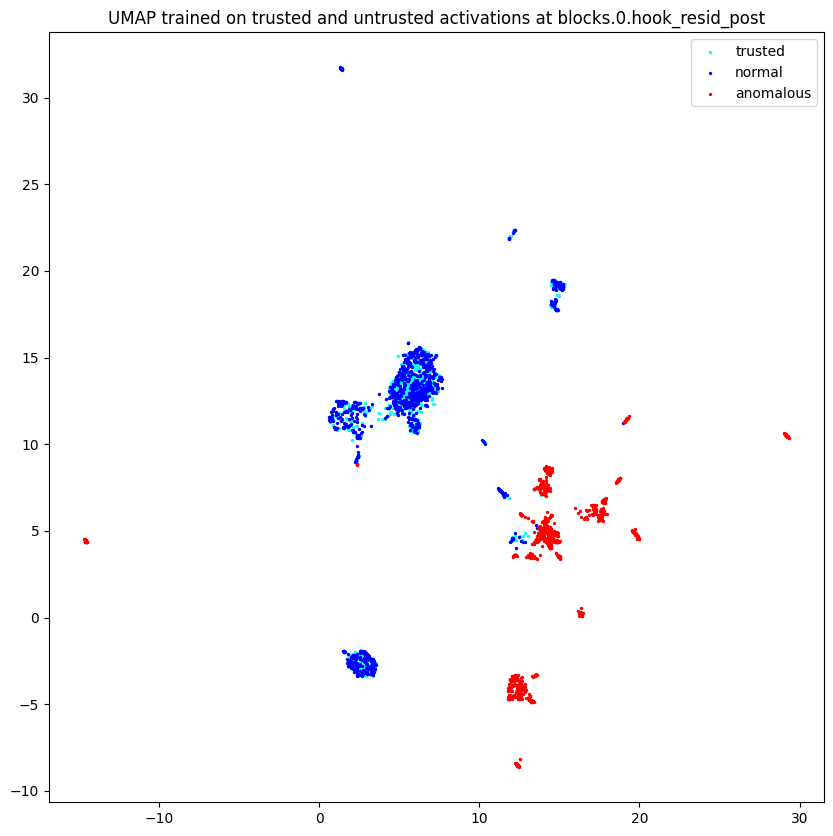

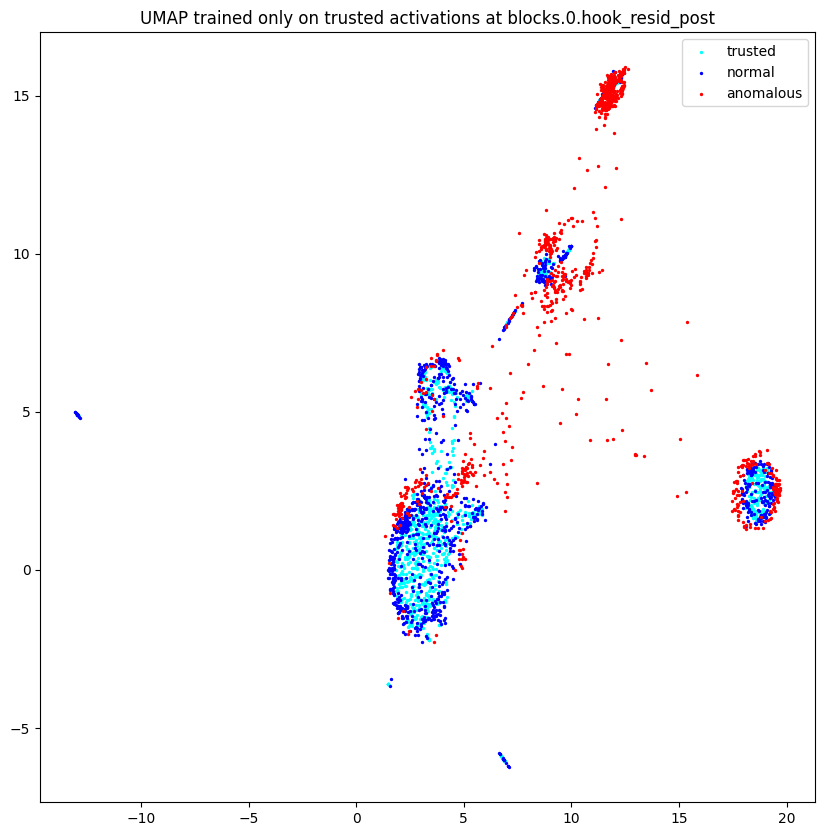

In [7]:
# UMAPs
for train_on_test_set in [True, False]:
    for hook_name in hook_names:
        umapper = umap.UMAP(n_neighbors=15, metric='euclidean')
        if train_on_test_set:
            mapper = umapper.fit(acts_combined[hook_name].to('cpu').detach().numpy())
        else:
            mapper = umapper.fit(acts_trusted[hook_name].to('cpu').detach().numpy())
        test_embedding_trusted = mapper.transform(acts_trusted[hook_name].to('cpu').detach().numpy())
        test_embedding_normal = mapper.transform(acts_normal[hook_name].to('cpu').detach().numpy())
        test_embedding_anomalous = mapper.transform(acts_anomalous[hook_name].to('cpu').detach().numpy())
        plt.rcParams['figure.figsize'] = [10, 10]
        plt.title(f'UMAP trained {"on trusted and untrusted" if train_on_test_set else "only on trusted"} activations at {hook_name}')
        plt.scatter(test_embedding_trusted[:, 0], test_embedding_trusted[:, 1], s= 2, c='aqua', label='trusted')
        plt.scatter(test_embedding_normal[:, 0], test_embedding_normal[:, 1], s= 2, c='blue', label='normal')
        plt.scatter(test_embedding_anomalous[:, 0], test_embedding_anomalous[:, 1], s= 2, c='red', label = 'anomalous')
        plt.legend()
        plt.show()

# Mahalanobis

2024-09-26 08:09:06.775 | DEBUG    | cupbearer.detectors.statistical.statistical:_train:53 - Collecting statistics on trusted data
2024-09-26 08:09:06.886 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:95 - Activation sizes: 
blocks.0.hook_resid_post.output: torch.Size([512])
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:09<00:00, 27.91it/s]
2024-09-26 08:09:19.307 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AUC_ROC (all): 0.9294
2024-09-26 08:09:19.311 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:346 - AP (all): 0.9013



Normal but high anomaly score:

#439 (2.657806158065796): |}'.format(Ċ                        'âĸ²' + str(ahead) if ahead| -> | else|
#842 (2.869173526763916): |])čĊčĊutc = pytz.utc if pytz| -> | else|
#366 (3.0893912315368652): |ata2ko if ruby == mecabdef.RB_HANGUL| -> | else|
#616 (3.355942964553833): |self, precipitation):Ċ        self._t = precipitation if precipitation > 0.0| -> | else|
#947 (3.367264986038208): |):ĊĊ        self._dlm = DataLifecycleManager() if useDLM| -> | else|
#104 (3.530184507369995): | surface backend to useĊSurface = GeglSurface if use_gegl| -> | else|
#67 (3.6816115379333496): |) does not mean that I am not a success in God's eyes if nowhere| -> | else|
#692 (3.851783275604248): |precio" : ing["precio"] if "precio" in ing| -> | else|
#646 (3.9678030014038086): |estObject = objĊ        c = rgba(sk.border if obj is sk| -> | else|
#149 (4.8930816650390625): | self.NRenderTargets:čĊ      W = self.W if not W| -> | else|

Anomalous but low anomaly score:

#1088

(defaultdict(dict,
             {'all': {'AUC_ROC': np.float64(0.9293785095214844),
               'AP': np.float64(0.9013302301878795)}}),
 {'all': <Figure size 1000x1000 with 1 Axes>})

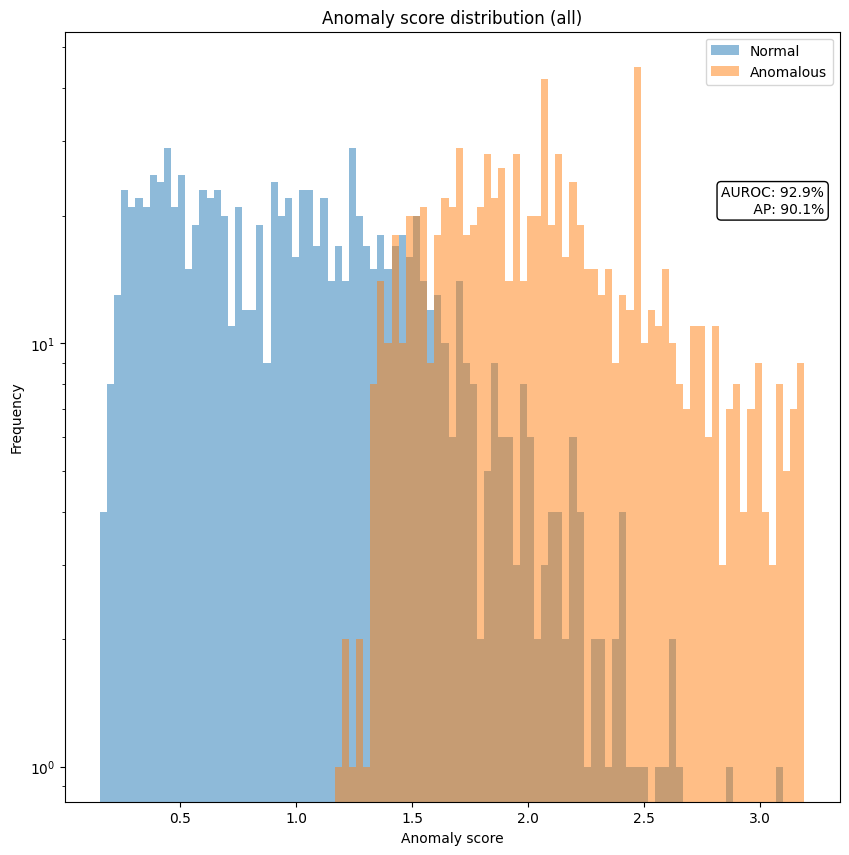

In [8]:

cache = detectors.FeatureCache(device=device)
mahalanobis_detector = detectors.MahalanobisDetector(activation_names=names, layer_aggregation="mean", individual_processing_fn=get_activation_at_last_token, cache=cache)
mahalanobis_detector.train(task, batch_size=64)
mahalanobis_detector.eval(dataset=task.test_data, batch_size=64, show_worst_mistakes=True, sample_format_fn=sample_format_fn)

# Mahalanobis on concatenated activations

2024-09-26 08:10:18.363 | DEBUG    | cupbearer.detectors.statistical.statistical:_train:53 - Collecting statistics on trusted data
2024-09-26 08:10:18.425 | DEBUG    | cupbearer.detectors.statistical.statistical:init_variables:95 - Activation sizes: 
blocks.0.hook_resid_post.output: torch.Size([512])
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:08<00:00, 31.80it/s]
2024-09-26 08:10:27.718 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AUC_ROC (all): 0.9294
2024-09-26 08:10:27.720 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:346 - AP (all): 0.9013



Normal but high anomaly score:

#439 (2.657805919647217): |}'.format(Ċ                        'âĸ²' + str(ahead) if ahead| -> | else|
#842 (2.869173288345337): |])čĊčĊutc = pytz.utc if pytz| -> | else|
#366 (3.089386463165283): |ata2ko if ruby == mecabdef.RB_HANGUL| -> | else|
#616 (3.355942487716675): |self, precipitation):Ċ        self._t = precipitation if precipitation > 0.0| -> | else|
#947 (3.36726450920105): |):ĊĊ        self._dlm = DataLifecycleManager() if useDLM| -> | else|
#104 (3.5301828384399414): | surface backend to useĊSurface = GeglSurface if use_gegl| -> | else|
#67 (3.6816139221191406): |) does not mean that I am not a success in God's eyes if nowhere| -> | else|
#692 (3.85178542137146): |precio" : ing["precio"] if "precio" in ing| -> | else|
#646 (3.967806816101074): |estObject = objĊ        c = rgba(sk.border if obj is sk| -> | else|
#149 (4.893081188201904): | self.NRenderTargets:čĊ      W = self.W if not W| -> | else|

Anomalous but low anomaly score:

#1088 (1.

(defaultdict(dict,
             {'all': {'AUC_ROC': np.float64(0.9293785095214844),
               'AP': np.float64(0.9013302301878795)}}),
 {'all': <Figure size 1000x1000 with 1 Axes>})

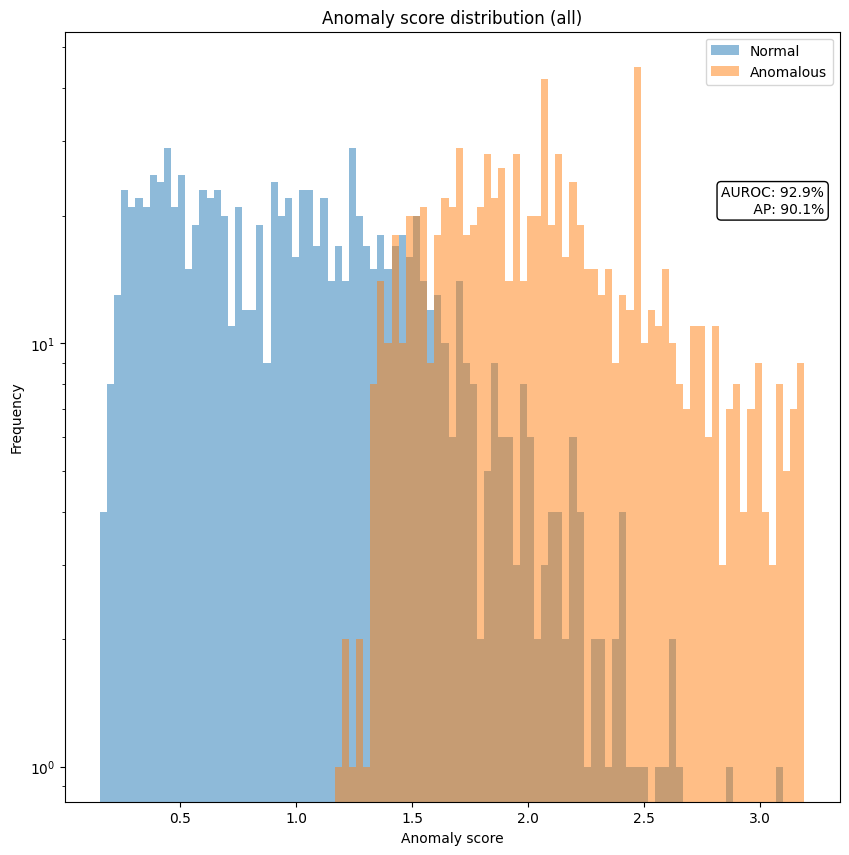

In [9]:
# This is extremely inefficient, because it recomputes with the same concatenated activations for each layer name
def concat_acts(acts_dict):
    concatenated = torch.cat([v for v in acts_dict.values()], dim=-1)
    return {name: concatenated for name in acts_dict}
    
cache = detectors.FeatureCache(device=device)
mahalanobis_concat_detector = detectors.MahalanobisDetector(activation_names=names, layer_aggregation="mean", individual_processing_fn=get_activation_at_last_token, global_processing_fn=concat_acts, cache=cache)
mahalanobis_concat_detector.train(task, batch_size=64)
mahalanobis_concat_detector.eval(dataset=task.test_data, batch_size=64, show_worst_mistakes=True, sample_format_fn=sample_format_fn)

# Variational AutoEncoder (VAE)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Moving model to device:  cuda


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | feature_model | VAEFeatureModel   | 1.1 M  | train
1 | model         | HookedTransformer | 51.0 M | eval 
------------------------------------------------------------
52.2 M    Trainable params
0         Non-trainable params
52.2 M    Total params
208.780   Total estimated model params size (MB)
12        Modules in train mode
31        Modules in eval mode
/home/jordan/miniconda3/envs/MAD/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:08<00:00, 31.62it/s, v_num=115, train/loss=0.0106]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:13<00:00, 19.36it/s, v_num=115, train/loss=0.0106]


2024-09-26 08:27:47.683 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AUC_ROC (all): 0.9001
2024-09-26 08:27:47.684 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:346 - AP (all): 0.8707



Normal but high anomaly score:

#957 (0.031591374427080154): |_slashes = (Ċ    "/" if settings.BLOG_SLUG| -> | else|
#824 (0.032008472830057144): | None:Ċ            new_names = deepcopy(self.names) if deep| -> | else|
#366 (0.03568816930055618): |ata2ko if ruby == mecabdef.RB_HANGUL| -> | else|
#947 (0.03685503453016281): |):ĊĊ        self._dlm = DataLifecycleManager() if useDLM| -> | else|
#104 (0.03758714348077774): | surface backend to useĊSurface = GeglSurface if use_gegl| -> | else|
#616 (0.03925095871090889): |self, precipitation):Ċ        self._t = precipitation if precipitation > 0.0| -> | else|
#67 (0.04258901625871658): |) does not mean that I am not a success in God's eyes if nowhere| -> | else|
#646 (0.04431585595011711): |estObject = objĊ        c = rgba(sk.border if obj is sk| -> | else|
#692 (0.04488545283675194): |precio" : ing["precio"] if "precio" in ing| -> | else|
#149 (0.06420178711414337): | self.NRenderTargets:čĊ      W = self.W if not W| -> | else|

Anomalous 

(defaultdict(dict,
             {'all': {'AUC_ROC': np.float64(0.9001474380493164),
               'AP': np.float64(0.8706963126797874)}}),
 {'all': <Figure size 1000x1000 with 1 Axes>})

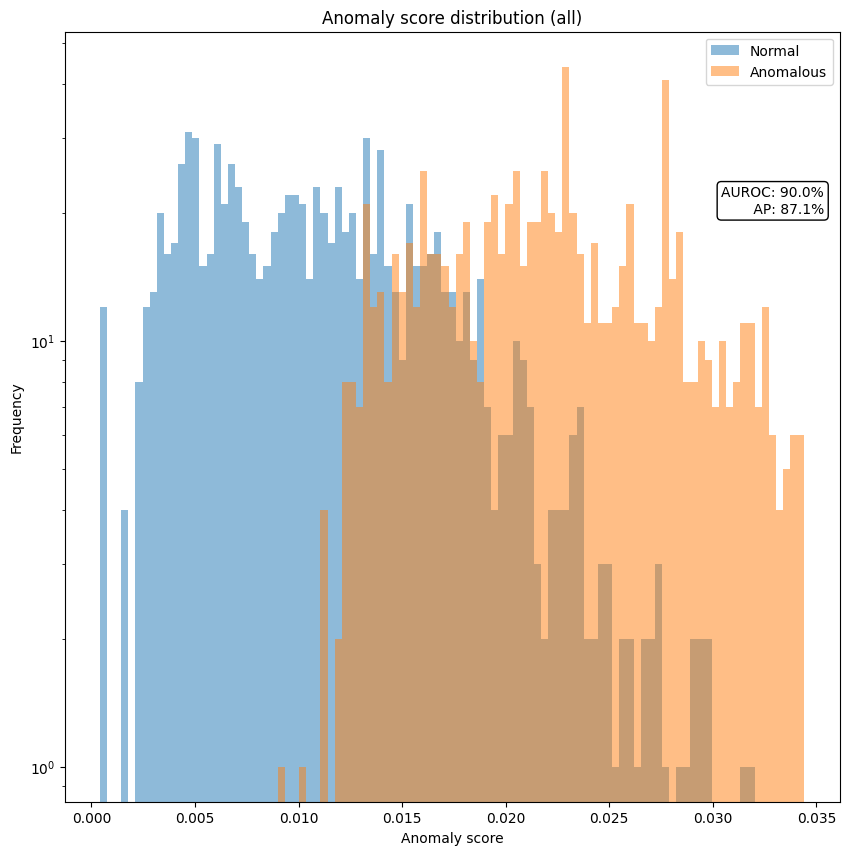

In [26]:
input_dim = 512
latent_dim = 128
kld_weight = 1e-5
vae = detectors.feature_model.VAE(input_dim, latent_dim)
cache = detectors.FeatureCache(device=device)
task.model.to(device)
vae_detector = detectors.VAEDetector({names[0]:vae}, kld_weight=kld_weight, individual_processing_fn=get_activation_at_last_token, cache=cache)
vae_detector.train(task, save_path=None, batch_size=64, max_epochs=5)
vae_detector.eval(dataset=task.test_data, batch_size=64, show_worst_mistakes=True, sample_format_fn=sample_format_fn)

In [8]:
# Hyperparameter search record: 

# # VAE hidden dimension : resulting AUC @ 1 epoch @ kld_weight = 1.0
# {
#     2:   75,
#     64:  79.4,
#     128: 80.7,
#     256: 79.8,
# }

# # Epochs : resulting AUC @ 128 hidden dimension @ kld_weight = 1.0
# {
#     1:  80.7,
#     2:  81.1,
#     5:  84.3,
# }

# # kld_weight : resulting AUC @ 1 epoch @ 128 hidden dimension
# {
#     1:    80.7,
#     1e-1: 83.4,
#     1e-2: 87.1,
#     1e-4: 89.5,
#     1e-5: 90.2,
#     1e-7: 89.7,
# }

# # Epochs : resulting AUC @ 128 hidden dimension @ kld_weight = 1e-5
# {
#     1:  90.2,
#     5:  92.0,
# }


# VAE with metric in output space rather than activation space (by patching)

In [11]:

from typing import Union, Callable
from cupbearer.detectors.feature_model.feature_model_detector import FeatureModel, FeatureModelDetector
# from cupbearer.detectors.feature_model.vae import VAE


# I've just modified the VAE class to allow for kl_div loss instead of mse.
class VAE(nn.Module):
    """Simple VAE with MLP encoder and decoder.

    Adapted from PyTorch VAE (Apache-2.0) but with a different architecture.
    https://github.com/AntixK/PyTorch-VAE/blob/master/models/vanilla_vae.py

    Original copyright notice:
                             Apache License
                       Version 2.0, January 2004
                    http://www.apache.org/licenses/
                    Copyright Anand Krishnamoorthy Subramanian 2020
                               anandkrish894@gmail.com
    """

    def __init__(self, input_dim: int, latent_dim: int):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 2 * input_dim),
            nn.ReLU(),
            nn.Linear(2 * input_dim, 2 * self.latent_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 2 * input_dim),
            nn.ReLU(),
            nn.Linear(2 * input_dim, input_dim),
        )

    def encode(self, input: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        assert input.ndim == 2
        result = self.encoder(input)
        assert result.ndim == 2
        assert result.shape[1] == 2 * self.latent_dim

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = result[:, : self.latent_dim]
        log_var = result[:, self.latent_dim :]

        return mu, log_var

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        return self.decoder(z)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(
        self, input: torch.Tensor, noise: bool = True, **kwargs
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, log_var = self.encode(input)
        if noise:
            z = self.reparameterize(mu, log_var)
        else:
            z = mu
        return self.decode(z), mu, log_var

    def loss_function(
        self, reconstruction, input, mu, log_var, kld_weight=1.0, reduce: bool = True, recon_method: str = "mse",
    ) -> dict[str, torch.Tensor]:
        """
        Computes the VAE loss function.
        KL(N(\\mu, \\sigma), N(0, 1)) =
        \\log \frac{1}{\\sigma} + \frac{\\sigma^2 + \\mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """

        # I've modified these lines to allow for kl_div reconstriction loss instead of mse, 
        # but performacnce is terrible with kl_div for now. Am I doing something wrong?
        if recon_method == "mse":
            recons_loss = nn.functional.mse_loss(reconstruction, input, reduction="none")
        elif recon_method == "kl_div":
            recons_loss = nn.functional.kl_div(reconstruction, input, reduction="none", log_target=True)
        else:
            assert False, "recon method should be mse or kld"
        # Reduce over all but first dimension
        recons_loss = recons_loss.view(recons_loss.shape[0], -1).mean(dim=1)

        kld_loss = -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1)

        if reduce:
            recons_loss = recons_loss.mean()
            kld_loss = kld_loss.mean()

        loss = recons_loss + kld_weight * kld_loss

        return {
            "loss": loss,
            "Reconstruction_Loss": recons_loss.detach(),
            "KLD": kld_loss.detach(),
        }


# The OutputVAEFeatureModel is like a VAEFeatureModel, except that it allows for a acts_to_outputs_fn, which changes the metric used for the reconstruction loss.
class OutputVAEFeatureModel(FeatureModel):
    def __init__(self, vaes: dict[str, VAE], kld_weight: float = 1.0, loss_recon_method='mse', acts_to_outputs_fn: Union[Callable, None] = None):
        super().__init__()
        if acts_to_outputs_fn is None:
            self.acts_to_outputs_fn = lambda x, input, name: x
        else:
            self.acts_to_outputs_fn = acts_to_outputs_fn
        self.vaes = utils.ModuleDict(vaes)
        self.kld_weight = kld_weight
        self.loss_recon_method = loss_recon_method

    @property
    def layer_names(self):
        return list(self.vaes.keys())

    def forward(
        self, inputs, features: dict[str, torch.Tensor], return_outputs: bool = False
    ) -> dict[str, torch.Tensor]:
        vae_outputs = {
            name: vae(features[name], noise=False) for name, vae in self.vaes.items()
        }
        # VAE outputs are (reconstruction, mu, log_var)
        reconstructions = {
            name: vae_output[0] for name, vae_output in vae_outputs.items()
        }
        mus = {name: vae_output[1] for name, vae_output in vae_outputs.items()}
        log_vars = {name: vae_output[2] for name, vae_output in vae_outputs.items()}

        losses = {
            name: self.vaes[name].loss_function(
                self.acts_to_outputs_fn(reconstructions[name], inputs, name),
                self.acts_to_outputs_fn(features[name], inputs, name),
                mus[name],
                log_vars[name],
                kld_weight=self.kld_weight,
                reduce=False,
                recon_method= self.loss_recon_method
            )
            for name in self.layer_names
        }
        if return_outputs:
            return losses, reconstructions, mus, log_vars

        return {name: loss["loss"] for name, loss in losses.items()}


class OutputVAEDetector(FeatureModelDetector):
    def __init__(self, vaes: dict[str, VAE], kld_weight: float = 1.0,  loss_recon_method='mse', acts_to_outputs_fn: Union[Callable, None] = None, **kwargs):
        super().__init__(OutputVAEFeatureModel(vaes, kld_weight=kld_weight, loss_recon_method=loss_recon_method, acts_to_outputs_fn=acts_to_outputs_fn), **kwargs)


# Patch the changed activation into the model's activations at the specified hook point, and get the logits.
def acts_to_outputs_fn(changed_activation: torch.Tensor, inputs: torch.Tensor, name: str, model: HookedTransformer):
    # Run a partial forward pass through the model, with activations at "name" hook point replaced by "activation"
    def patching_hook(activation, hook):
        if activation.ndim == 3:
            # Residual stream or equivalent, shape is (batch, seq, hidden)
            activation[:, -1, :] = changed_activation
        elif activation.ndim == 4 and activation.shape[-1] == activation.shape[-2]:
            # Attention, shape is (batch, num_heads, query, key)
            # TODO: this could also be Q/K/V if n_heads happens to be head_dim
            activation[:, :, -1, :] = changed_activation.reshape(activation.shape[0], activation.shape[1], -1)
        elif activation.ndim == 4:
            # Query/key/value, shape is (batch, seq, num_heads, hidden)
            activation[:, -1, :, :] = changed_activation.reshape(activation.shape[0], activation.shape[2], -1)
        else:
            raise ValueError(f"Unexpected activation shape: {activation.shape}")
        return activation
    # TODO: increase efficiency by starting at a later layer, and passing the cached input activations there if necessary.
    hook_name = name.replace('.output', '') 
    patched_logits = model.run_with_hooks(inputs, fwd_hooks=[(hook_name, patching_hook)])
    return patched_logits


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs




epochs = 1, input_dim = 512, latent_dim = 128, kld_weight = 1e-05, loss_recon_method = mse name = blocks.0.hook_resid_post.output
Moving model to device:  cuda


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                  | Params | Mode 
----------------------------------------------------------------
0 | feature_model | OutputVAEFeatureModel | 1.4 M  | train
1 | model         | HookedTransformer     | 51.0 M | eval 
----------------------------------------------------------------
52.5 M    Trainable params
0         Non-trainable params
52.5 M    Total params
209.960   Total estimated model params size (MB)
12        Modules in train mode
31        Modules in eval mode
/home/jordan/miniconda3/envs/MAD/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [01:23<00:00,  3.06it/s, v_num=109, train/loss=0.0618]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [01:28<00:00,  2.91it/s, v_num=109, train/loss=0.0618]


2024-09-26 08:13:28.849 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AUC_ROC (all): 0.7296
2024-09-26 08:13:28.850 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:346 - AP (all): 0.6521



Normal but high anomaly score:

#250 (0.12364012002944946): |080,Ċ        'properties': {Ċ            ('MD' if capitalize| -> | else|
#152 (0.12545208632946014): |('utf-8') if six.PY2 or not USE_LUA| -> | else|
#689 (0.12924198806285858): | else FalseĊ            prioriy = ap["priority"] if "priority" in ap| -> | else|
#598 (0.13023288547992706): |_save['restraints']    = {} if 'restraints' in minimal| -> | else|
#409 (0.1334851086139679): |.OUT, initial=self._gpio.LOW if self._cs_high| -> | else|
#336 (0.1338130682706833): | 'died': p.datedeath.year if p.datedeath| -> | else|
#104 (0.13394540548324585): | surface backend to useĊSurface = GeglSurface if use_gegl| -> | else|
#340 (0.1346169412136078): |Ċ        raise ValueError('view')ĊĊ    fmt = '>' if is_be| -> | else|
#601 (0.14119775593280792): | at %s again in %s" %Ċ                   ("ALL" if all_| -> | else|
#732 (0.14420004189014435): |Ċ    comm_size = optimizer.comm.size if optimizer.comm| -> | else|

Anomalous but low anomal

(defaultdict(dict,
             {'all': {'AUC_ROC': np.float64(0.7295637130737305),
               'AP': np.float64(0.6521368936031893)}}),
 {'all': <Figure size 1000x1000 with 1 Axes>})

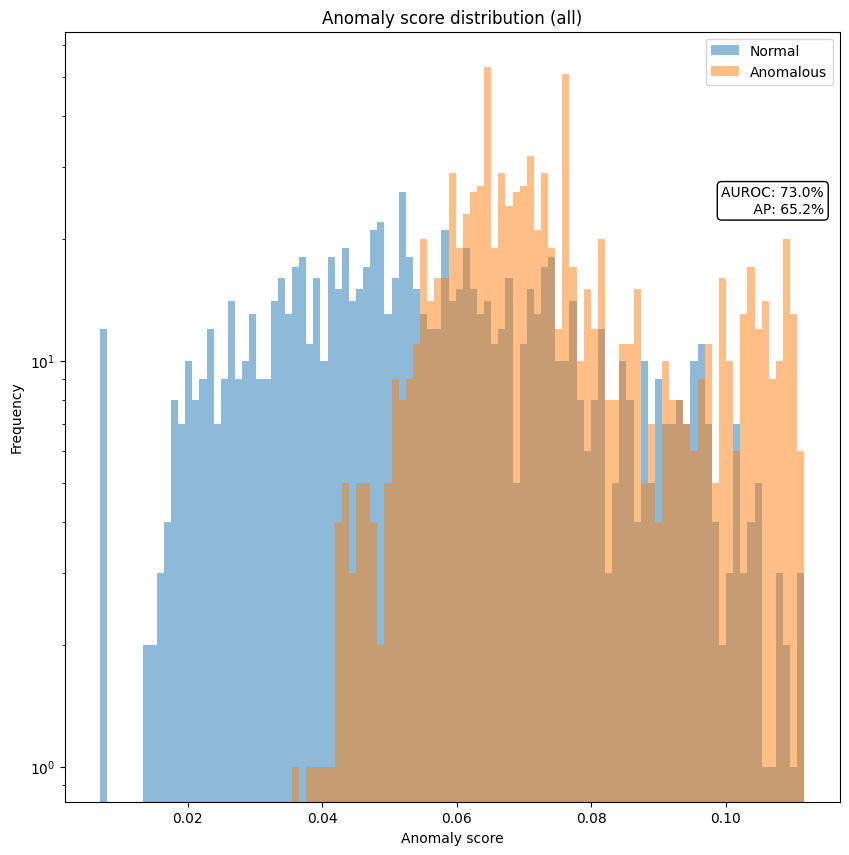

In [12]:


# Test the output VAE detector
epochs = 1
input_dim = 512
latent_dim = 128
kld_weight = 1e-5
loss_recon_method = 'mse'
name = names[0]

print(f'\n\nepochs = {epochs}, input_dim = {input_dim}, latent_dim = {latent_dim}, kld_weight = {kld_weight}, loss_recon_method = {loss_recon_method} name = {name}')
output_vae = detectors.feature_model.VAE(input_dim, latent_dim)
cache = detectors.FeatureCache(device=device)
model = task.model.to(device)#.eval()
output_vae_detector = OutputVAEDetector({name:output_vae}, kld_weight=kld_weight, loss_recon_method=loss_recon_method, acts_to_outputs_fn=partial(acts_to_outputs_fn, model=model), individual_processing_fn=get_activation_at_last_token, cache=cache)
output_vae_detector.train(task, save_path=None, batch_size=64, max_epochs=epochs)
output_vae_detector.eval(dataset=task.test_data, batch_size=64, show_worst_mistakes=True, sample_format_fn=sample_format_fn)


In [13]:
# Output VAE Hyperparam tuning

# using KL_div:
# epochs = 1
# input_dim = 512
# latent_dim = 128
    
    # kld_weight = 1e-5
    # --> AUC = 45.4

    # kld_weight = 1e-1
    # --> AUC = 45.2


# using MSE:
# epochs = 1
# input_dim = 512
# latent_dim = 128

    # kld_weight = 1e-7
    # --> AUC = 82.7

    # kld_weight = 1e-6
    # --> AUC = 83.1

    # kld_weight = 1e-5
    # --> AUC = 82.5 ?

    # kld_weight = 1e-3
    # --> AUC = 81.7

    # kld_weight = 1e-1
    # --> AUC = 80.8


# using MSE:
# epochs = 5
# input_dim = 512
# latent_dim = 128

    # kld_weight = 1e-5
    # --> AUC = 85.0

# OutputVAE in the space of *relevant* tokens (by patching)

In [30]:
# Get the relevant tokens for this task
with open(".cupbearer_cache/tiny_natural_mechanisms/ifelse_task.json") as f:
    task_config = json.load(f)

effect_tokens = torch.tensor(task_config["effect_tokens"], dtype=torch.long).to(device)
task.model.to(device)
print(f'effect token strings = {task.model.tokenizer.convert_ids_to_tokens(effect_tokens)}')


# A class for selecting only the relevant tokens from the logits
class TokenSelector(nn.Module):
    def __init__(self, effect_tokens):
        super().__init__()
        self.effect_tokens_mask = torch.zeros(
            task.model.cfg.d_vocab, dtype=torch.bool, device=effect_tokens.device
        )
        self.effect_tokens_mask[effect_tokens] = True
        self.non_effect_tokens_mask = ~self.effect_tokens_mask

        # # # Take just the relevant rows of the unembed 
        # self.W_U_selected = task.model.W_U[:, self.effect_tokens_mask].clone().detach()
        # self.W_U_selected_inv = torch.linalg.pinv(self.W_U_selected) # shape (effect_tokens, hidden)
        # self.W_U_selected_inv = self.W_U_selected_inv

    def forward(self, logits):
        assert logits.ndim >= 2, logits.shape
        # probs = torch.softmax(logits, dim=-1)
        selected_logits = logits[..., self.effect_tokens_mask]
        return selected_logits
        # selected_logits_in_latent_space = selected_logits @ self.W_U_selected_inv #torch.einsum('...e,eh->...h', selected_logits, self.W_U_selected_inv )
        # return selected_logits_in_latent_space
    
select_relevant_tokens = TokenSelector(effect_tokens)

# Patch the changed activation into the model's activations at the specified hook point, and get the relevant logits.
def acts_to_relevant_outputs_fn(changed_activation: torch.Tensor, inputs: torch.Tensor, name: str, model: HookedTransformer):
    # Run a partial forward pass through the model, with activations at "name" hook point replaced by "activation"
    def patching_hook(activation, hook):
        if activation.ndim == 3:
            # Residual stream or equivalent, shape is (batch, seq, hidden)
            activation[:, -1, :] = changed_activation
        elif activation.ndim == 4 and activation.shape[-1] == activation.shape[-2]:
            # Attention, shape is (batch, num_heads, query, key)
            # TODO: this could also be Q/K/V if n_heads happens to be head_dim
            activation[:, :, -1, :] = changed_activation.reshape(activation.shape[0], activation.shape[1], -1)
        elif activation.ndim == 4:
            # Query/key/value, shape is (batch, seq, num_heads, hidden)
            activation[:, -1, :, :] = changed_activation.reshape(activation.shape[0], activation.shape[2], -1)
        else:
            raise ValueError(f"Unexpected activation shape: {activation.shape}")
        return activation
    # TODO: increase efficiency by starting at a later layer, and passing the cached input activations there if necessary.
    hook_name = name.replace('.output', '') 
    # Get the logits from the model with the changed activation
    patched_logits = model.run_with_hooks(inputs, fwd_hooks=[(hook_name, patching_hook)])
    # return only the relevant logits
    return select_relevant_tokens(patched_logits)


Moving model to device:  cuda
effect token strings = ['Ġelse']


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs




epochs = 1, input_dim = 512, latent_dim = 32, kld_weight = 0.0001, loss_recon_method = mse name = blocks.0.hook_resid_post.output
Moving model to device:  cuda


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                  | Params | Mode 
----------------------------------------------------------------
0 | feature_model | OutputVAEFeatureModel | 1.1 M  | train
1 | model         | HookedTransformer     | 51.0 M | eval 
----------------------------------------------------------------
52.2 M    Trainable params
0         Non-trainable params
52.2 M    Total params
208.780   Total estimated model params size (MB)
12        Modules in train mode
31        Modules in eval mode
/home/jordan/miniconda3/envs/MAD/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [01:27<00:00,  2.93it/s, v_num=116, train/loss=0.0103]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [01:32<00:00,  2.76it/s, v_num=116, train/loss=0.0103]


2024-09-26 08:52:28.488 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AUC_ROC (all): 0.8185
2024-09-26 08:52:28.489 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:346 - AP (all): 0.8415



Normal but high anomaly score:

#822 (0.05944383144378662): |)ĊJAVA_CMD = 'java' if not JAVA_HOME| -> | else|
#149 (0.05973904952406883): | self.NRenderTargets:čĊ      W = self.W if not W| -> | else|
#243 (0.06082189083099365): |Ċ            edited_comment.get_message() if edited_comment is not None| -> | else|
#740 (0.06311087310314178): | new_method = 'HEAD' if rreq.method == 'HEAD'| -> | else|
#824 (0.06551729887723923): | None:Ċ            new_names = deepcopy(self.names) if deep| -> | else|
#75 (0.06678884476423264): |objects.get(pk = val_annee) if val_annee| -> | else|
#898 (0.06948631256818771): |dialog.groupBox.currentText()Ċ            group = newgroup if newgroup| -> | else|
#968 (0.0789807066321373): | horse in rehab without at least scoping her to rule them out if nothing| -> | else|
#262 (0.0829271674156189): |: [ np.concatenate((next_obs, [1 if done| -> | else|
#712 (0.08964727818965912): |, sonâĢĿâĢ¦ (fill in the blank) should not feel OK if someone| -> | else|

Anomalo

(defaultdict(dict,
             {'all': {'AUC_ROC': np.float64(0.818450927734375),
               'AP': np.float64(0.8414508216998249)}}),
 {'all': <Figure size 1000x1000 with 1 Axes>})

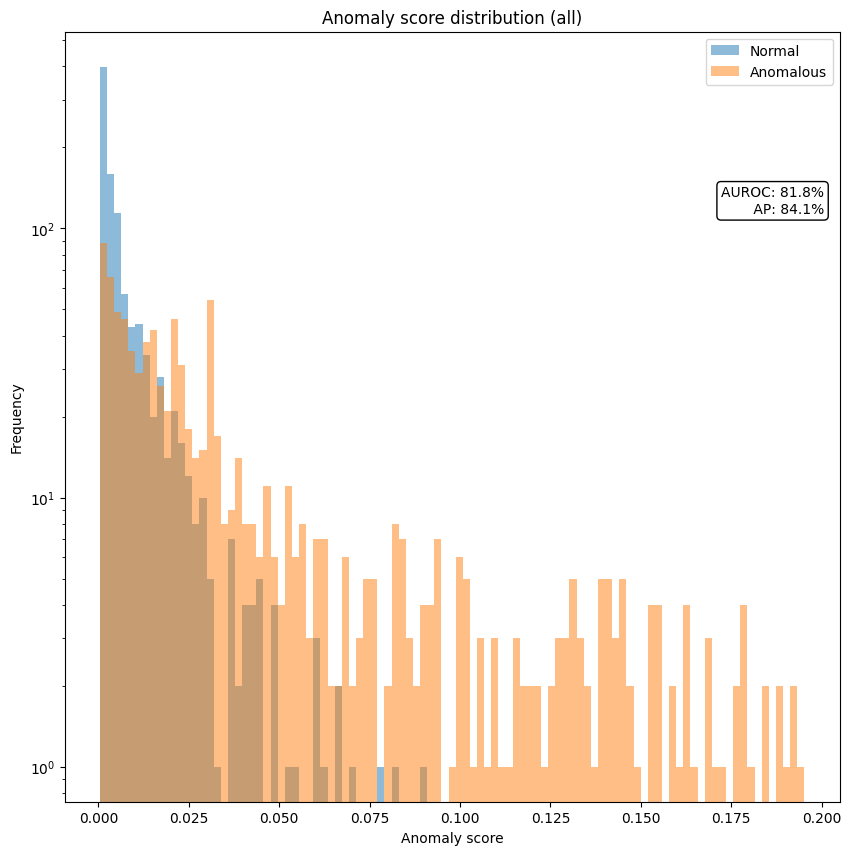

In [31]:
# Test the output VAE detector
epochs = 1
input_dim = 512
latent_dim = 32
kld_weight = 1e-4
loss_recon_method = 'mse'
name = names[0]

print(f'\n\nepochs = {epochs}, input_dim = {input_dim}, latent_dim = {latent_dim}, kld_weight = {kld_weight}, loss_recon_method = {loss_recon_method} name = {name}')
output_vae = detectors.feature_model.VAE(input_dim, latent_dim)
cache = detectors.FeatureCache(device=device)
model = task.model.to(device)#.eval()
output_vae_detector = OutputVAEDetector({name:output_vae}, kld_weight=kld_weight, loss_recon_method=loss_recon_method, acts_to_outputs_fn=partial(acts_to_relevant_outputs_fn, model=model), individual_processing_fn=get_activation_at_last_token, cache=cache)
output_vae_detector.train(task, save_path=None, batch_size=64, max_epochs=epochs)
output_vae_detector.eval(dataset=task.test_data, batch_size=64, show_worst_mistakes=True, sample_format_fn=sample_format_fn)


In [41]:
# relevance-filtered VAE Hyperparam tuning

    # input_dim = 512
    # latent_dim = 128
    # kld_weight = 1e-5
    # loss_recon_method = 'mse'
    # relevant_only = True

        # softmax = True
            # --> AUC = 52.8 %

        # softmax = False
            # epochs = 1
                # --> AUC = 84.3 %
            # epochs = 5
                # --> AUC = 87.2 %

    # A modest improvement upon the regular OutputVAE 
    
# Converting back to latent space with 
# selected_logits = logits[..., self.effect_tokens_mask]
# selected_logits_in_latent_space = selected_logits @ self.W_U_selected_inv

    # input_dim = 512
    # latent_dim = 128
    # kld_weight = 1e-5
    # loss_recon_method = 'mse'
    # relevant_only = True
        # softmax = False
            # epochs = 1
                # --> AUC = 85.4 %
            # epochs = 5
                # --> AUC = 85.3 %


# Simplified OutputVAE in the space of relevant tokens 
### (linear pullback only: no patching or gradients)

Moving model to device:  cuda
effect token strings = ['Ġelse']
Metric: torch.Size([512, 512])


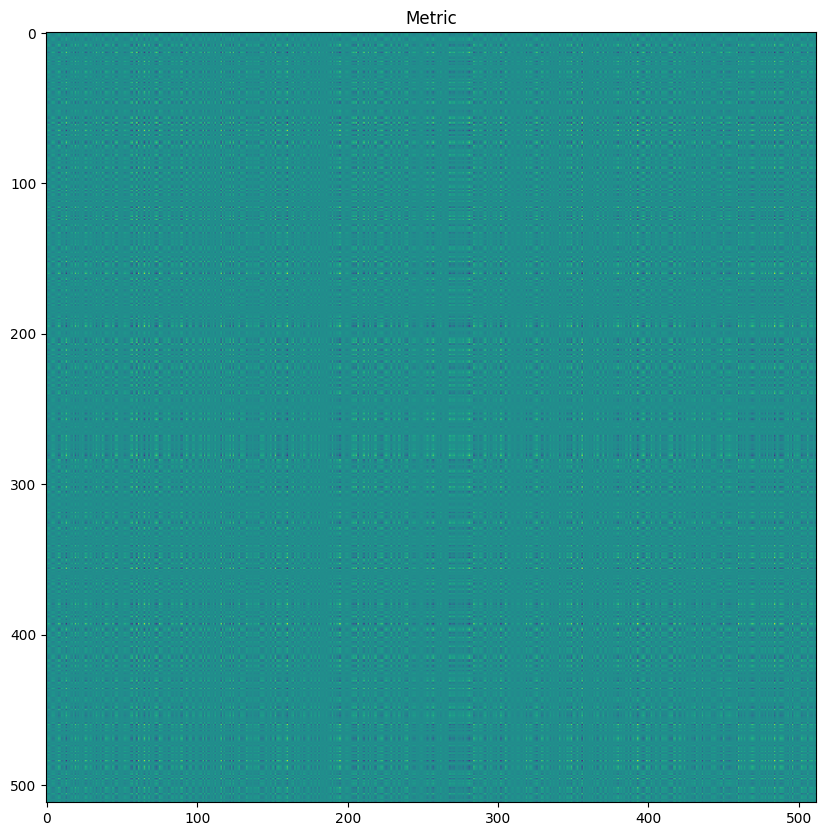

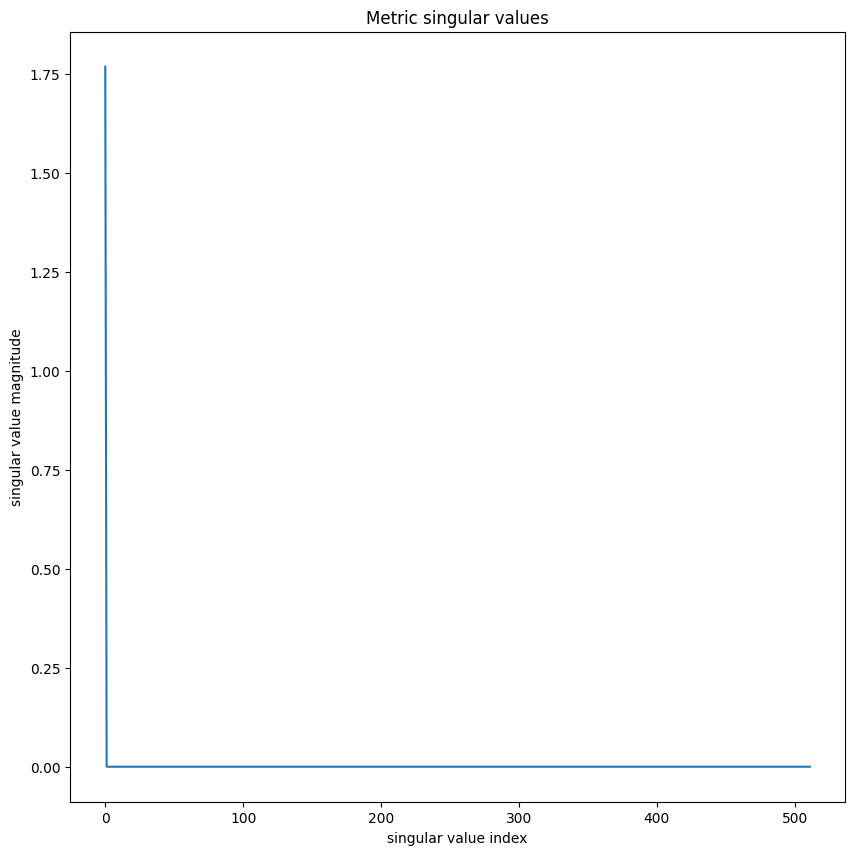

In [44]:
# Get the relevant tokens for this task
with open(".cupbearer_cache/tiny_natural_mechanisms/ifelse_task.json") as f:
    task_config = json.load(f)

effect_tokens = torch.tensor(task_config["effect_tokens"], dtype=torch.long).to(device)
task.model.to(device)
print(f'effect token strings = {task.model.tokenizer.convert_ids_to_tokens(effect_tokens)}')

# Get a metric squishing the latent space in the residual stream based on the projection onto the effect tokens
W_U_selected = task.model.W_U[:, effect_tokens].clone().detach()                   # shape (hidden, effect_tokens)
U_hidden, svals, U_tokens = torch.linalg.svd(W_U_selected, full_matrices=False)    # shape (hidden, effect_tokens), (effect_tokens), (effect_tokens, effect_tokens)
metric = U_hidden @ torch.diag(svals) @ U_hidden.T.conj()                          # shape (hidden, hidden)


print(f'Metric: {metric.shape}')
plt.imshow(metric.clone().detach().cpu().numpy())
plt.title('Metric')
plt.show()
plt.plot(np.pad(svals.clone().detach().cpu().numpy(), (0,len(metric)-len(svals))))
plt.title('Metric singular values')
plt.ylabel('singular value magnitude')
plt.xlabel('singular value index')
plt.show()

# Warp the activations with the metric.
def acts_warping_fn(activation: torch.Tensor, inputs: torch.Tensor, name: str):
    return activation @ metric

    



epochs = 2, input_dim = 512, latent_dim = 32, kld_weight = 0.0001, loss_recon_method = mse name = blocks.0.hook_resid_post.output
Moving model to device:  cuda


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                  | Params | Mode 
----------------------------------------------------------------
0 | feature_model | OutputVAEFeatureModel | 1.1 M  | train
1 | model         | HookedTransformer     | 51.0 M | eval 
----------------------------------------------------------------
52.2 M    Trainable params
0         Non-trainable params
52.2 M    Total params
208.780   Total estimated model params size (MB)
12        Modules in train mode
31        Modules in eval mode
/home/jordan/miniconda3/envs/MAD/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:09<00:00, 28.09it/s, v_num=118, train/loss=5.59e-6]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:12<00:00, 19.81it/s, v_num=118, train/loss=5.59e-6]


2024-09-26 08:54:57.536 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AUC_ROC (all): 0.6761
2024-09-26 08:54:57.538 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:346 - AP (all): 0.6359



Normal but high anomaly score:

#586 (3.61542115570046e-05): |Comment=" else lĊ                    l = l + command if l == "Exec="| -> | else|
#692 (3.660270886030048e-05): |precio" : ing["precio"] if "precio" in ing| -> | else|
#828 (4.2203952034469694e-05): |obj(base)Ċ    subclasses_type = dict if seven.PY3| -> | else|
#314 (4.385784632177092e-05): |accounts.find(from_, AccountType.Income) if from_| -> | else|
#195 (4.4786385842598975e-05): | = m.addAction(self.checked if vl == current_lib| -> | else|
#56 (4.6001910959603265e-05): |['title_romaji'] if 'title_romaji' in ani| -> | else|
#761 (5.6288270570803434e-05): |"]ĊADS_APPROVED = True if AD_SLOTS| -> | else|
#646 (0.0001271399378310889): |estObject = objĊ        c = rgba(sk.border if obj is sk| -> | else|
#616 (0.00015405764861498028): |self, precipitation):Ċ        self._t = precipitation if precipitation > 0.0| -> | else|
#67 (0.00017313520947936922): |) does not mean that I am not a success in God's eyes if nowhere| -> | else

(defaultdict(dict,
             {'all': {'AUC_ROC': np.float64(0.6760711669921875),
               'AP': np.float64(0.6358843880792345)}}),
 {'all': <Figure size 1000x1000 with 1 Axes>})

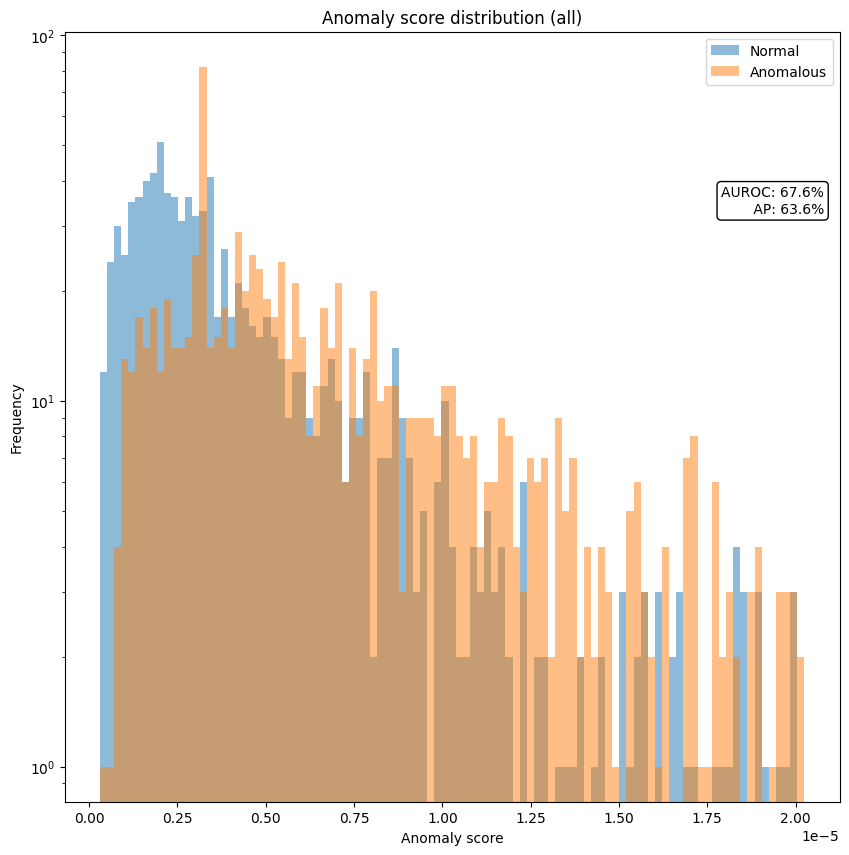

In [45]:

# Test the output VAE detector
epochs = 2
input_dim = 512
latent_dim = 32
kld_weight = 1e-4
loss_recon_method = 'mse'
# name = "blocks.0.hook_attn_out.output"
name = names[0]

print(f'\n\nepochs = {epochs}, input_dim = {input_dim}, latent_dim = {latent_dim}, kld_weight = {kld_weight}, loss_recon_method = {loss_recon_method} name = {name}')
output_vae = detectors.feature_model.VAE(input_dim, latent_dim)
cache = detectors.FeatureCache(device=device)
model = task.model.to(device)#.eval()
output_vae_detector = OutputVAEDetector({name:output_vae}, kld_weight=kld_weight, loss_recon_method=loss_recon_method, acts_to_outputs_fn=acts_warping_fn, individual_processing_fn=get_activation_at_last_token, cache=cache)
output_vae_detector.train(task, save_path=None, batch_size=64, max_epochs=epochs)
output_vae_detector.eval(dataset=task.test_data, batch_size=64, show_worst_mistakes=True, sample_format_fn=sample_format_fn)

In [35]:
# Hyperparameter search record: 
# input_dim = 512
# loss_recon_method = 'mse'
# name = "blocks.0.hook_attn_out.output"

    # latent_dim = 128

        # kld_weight = 5e-3
            # epochs = 2
                # AUROC 88.1%

        # kld_weight = 1e-3
            # epochs = 2
                # AUROC 87.2%

        # kld_weight = 5e-4
            # epochs = 2
                # AUROC 88.6%

        # kld_weight = 2e-4
            # epochs = 2
                # AUROC 87.2%

        # kld_weight = 1e-4
            # epochs = 2
                # AUROC 89.3%
            # epochs = 5
                # AUROC 89.5%

        # kld_weight = 5e-5
            # epochs = 2
                # AUROC 89.1%
            # epochs = 5
                # AUROC 88.3%

        # kld_weight = 1e-5
            # epochs = 1
                # AUROC 87.8%
            # epochs = 2
                # AUROC 88.7%
            # epochs = 3
                # AUROC 88.6%
            # epochs = 4
                # AUROC 88.3%

        # kld_weight = 1e-7
            # epochs = 2
                # AUROC 85.4%


    # latent_dim = 32
        # kld_weight = 1e-4
            # epochs = 2
                # AUROC 89.0%
            # epochs = 4
                # AUROC 89.5%

    # latent_dim = 64
        # kld_weight = 1e-4
            # epochs = 2
                # AUROC 88.0%

# Supervised linear skyline

In [36]:
n_train = 512
clean_train_data = Subset(task.test_data.normal_data, range(n_train))
clean_test_data = Subset(task.test_data.normal_data, range(n_train, 1024))
anomalous_train_data = Subset(task.test_data.anomalous_data, range(n_train))
anomalous_test_data = Subset(task.test_data.anomalous_data, range(n_train, 1024))

supervised_task = tasks.Task.from_separate_data(
    model=task.model,
    trusted_data=task.trusted_data,
    clean_test_data=clean_test_data,
    anomalous_test_data=anomalous_test_data,
    clean_untrusted_data=clean_train_data,
    anomalous_untrusted_data=anomalous_train_data,
    untrusted_labels=True,
)

In [37]:
supervised_detector = detectors.SupervisedLinearProbe(activation_names=[names[0]], individual_processing_fn=get_activation_at_last_token)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 24.75it/s]


activations.shape = (1024, 512), anomaly_labels.shape = (1024,)


2024-09-26 08:53:18.124 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AUC_ROC (all): 0.9998
2024-09-26 08:53:18.125 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:346 - AP (all): 0.9998


(defaultdict(dict,
             {'all': {'AUC_ROC': np.float64(0.9997806549072266),
               'AP': np.float64(0.9997660713733796)}}),
 {'all': <Figure size 1000x1000 with 1 Axes>})

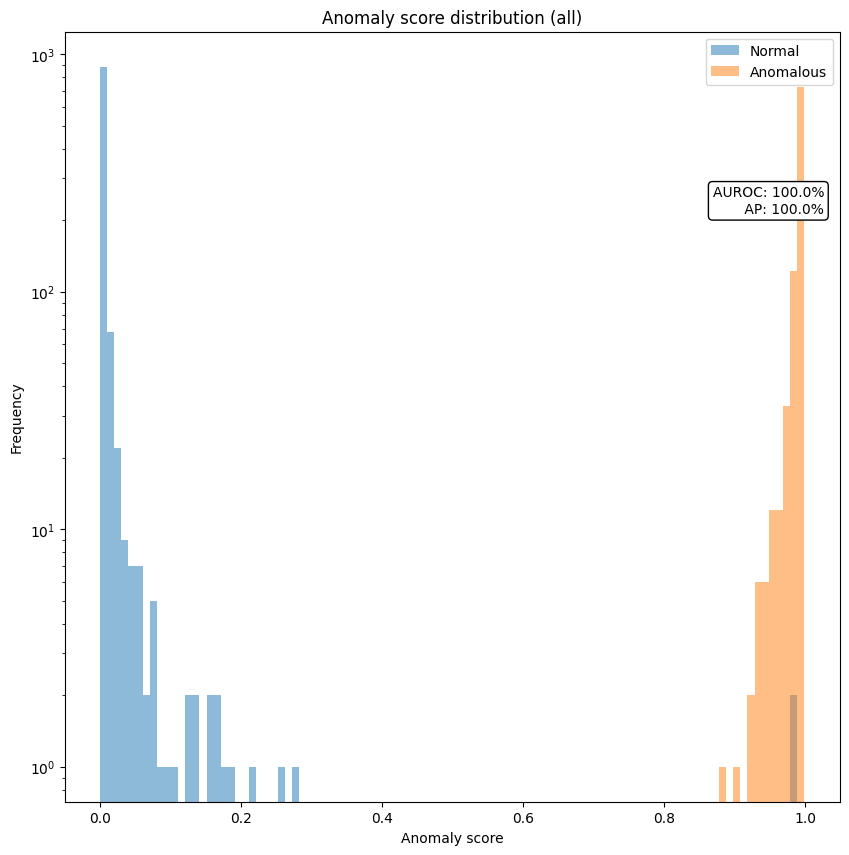

In [38]:
supervised_detector.train(supervised_task, batch_size=64)
supervised_detector.eval(dataset=task.test_data, batch_size=64)

# Supervised linear skyline on the output logits

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.98it/s]


activations.shape = (1024, 48262), anomaly_labels.shape = (1024,)


2024-09-26 08:53:31.011 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AUC_ROC (all): 0.9997
2024-09-26 08:53:31.021 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:346 - AP (all): 0.9997


(defaultdict(dict,
             {'all': {'AUC_ROC': np.float64(0.9997215270996094),
               'AP': np.float64(0.9996974833286898)}}),
 {'all': <Figure size 1000x1000 with 1 Axes>})

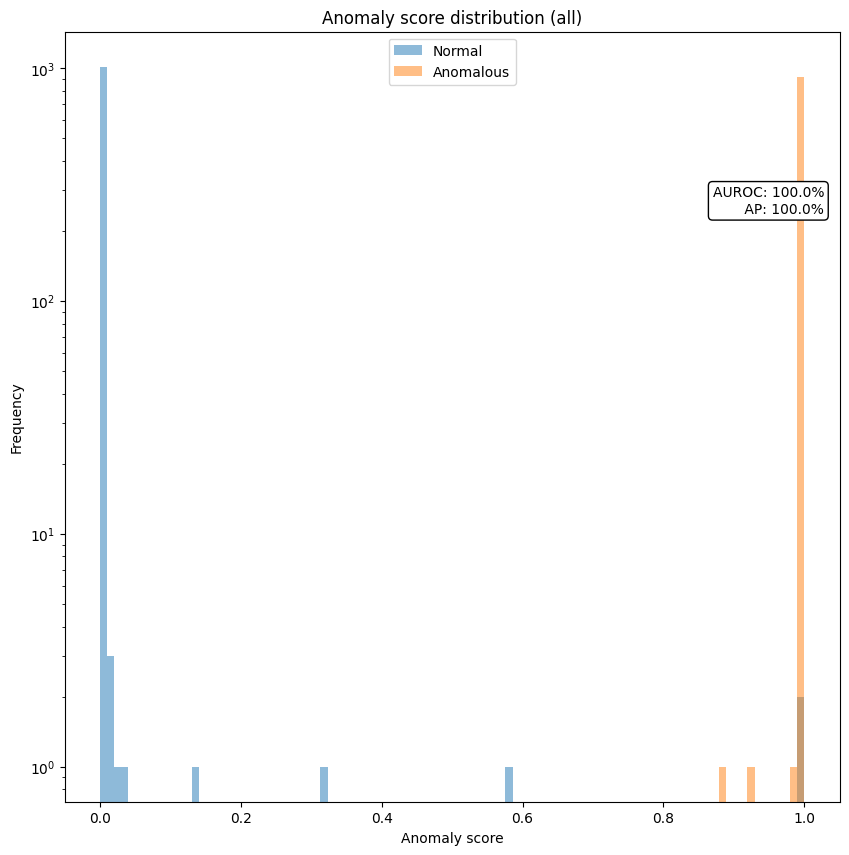

In [39]:
supervised_detector = detectors.SupervisedLinearProbe(activation_names=["unembed.output"], individual_processing_fn=get_activation_at_last_token)
supervised_detector.train(supervised_task, batch_size=64)
supervised_detector.eval(dataset=task.test_data, batch_size=64)

# Supervised linear skyline on only the relevant output logits

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16.49it/s]


activations.shape = (1024, 1), anomaly_labels.shape = (1024,)


2024-09-26 08:55:02.497 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:345 - AUC_ROC (all): 0.5465
2024-09-26 08:55:02.499 | INFO     | cupbearer.detectors.anomaly_detector:get_eval_results:346 - AP (all): 0.4865


(defaultdict(dict,
             {'all': {'AUC_ROC': np.float64(0.5465278625488281),
               'AP': np.float64(0.48647784771698815)}}),
 {'all': <Figure size 1000x1000 with 1 Axes>})

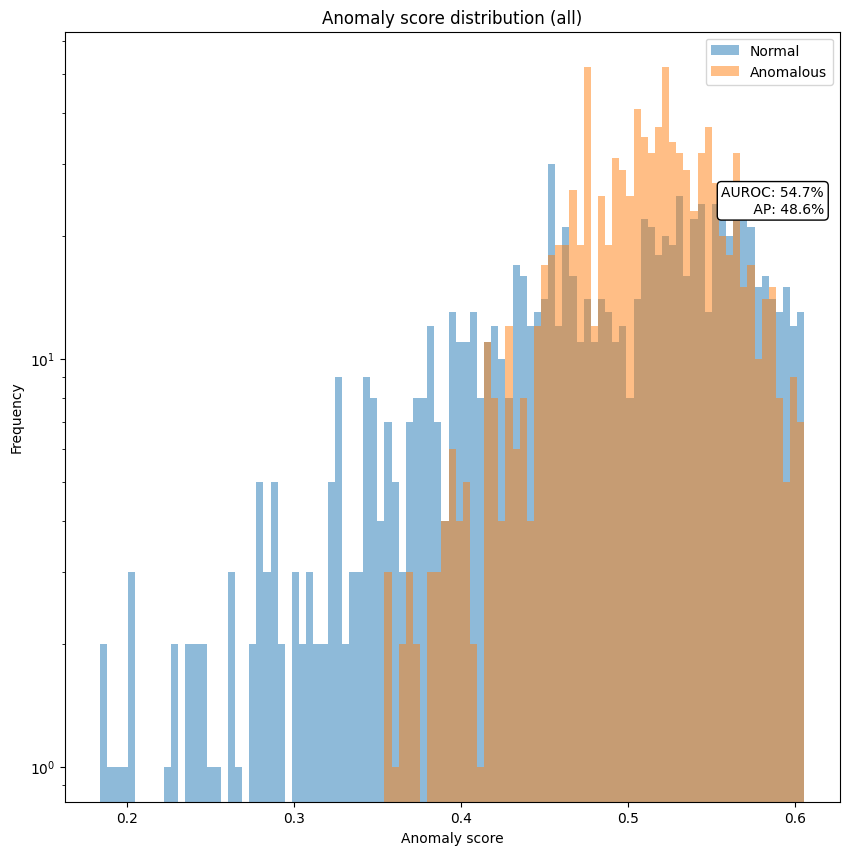

In [46]:
def get_relevant_activation_at_last_token(
    activation: torch.Tensor, *args,
):
    return activation[:, -1, effect_tokens]
    

supervised_detector = detectors.SupervisedLinearProbe(activation_names=["unembed.output"], individual_processing_fn=get_relevant_activation_at_last_token)
supervised_detector.train(supervised_task, batch_size=64)
supervised_detector.eval(dataset=task.test_data, batch_size=64)

In [47]:
effect_tokens

tensor([1952], device='cuda:0')

# LCAs

In [51]:
class ElementwiseLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        shape = x.shape[:-1]
        assert x.ndim >= 3, shape
        assert x.shape[-1] == self.linear.in_features, (
            x.shape,
            self.linear.in_features,
        )
        out_shape = x.shape[:-1] + (self.linear.out_features,)
        return self.linear(x.view(-1, x.shape[-1])).view(*out_shape)

In [52]:
with bf.BlobFile("gs://arc-ml-public/distinctions/datasets/hex_task.json") as f:
    task_config = json.load(f)

# cpu to avoid MPS issues with tensors that are too large
effect_tokens = torch.tensor(
    task_config["effect_tokens"], dtype=torch.long, device="cpu"
)


class Quotient(nn.Module):
    def __init__(self, effect_tokens):
        super().__init__()
        self.effect_tokens_mask = torch.zeros(
            task.model.cfg.d_vocab, dtype=torch.bool, device=effect_tokens.device
        )
        self.effect_tokens_mask[effect_tokens] = True
        self.non_effect_tokens_mask = ~self.effect_tokens_mask

    def forward(self, logits):
        assert logits.ndim >= 2, logits.shape
        probs = torch.softmax(logits, dim=-1)
        return torch.stack(
            [
                probs[..., self.effect_tokens_mask].sum(dim=-1),
                probs[..., self.non_effect_tokens_mask].sum(dim=-1),
            ],
            dim=-1,
        )

In [53]:
config = deepcopy(task.model.cfg)
config.d_model = 64
config.d_head = 8
config.d_mlp = 256  # Kind of unnecessary since this is attn-only
config.d_vocab_out = 2  # We only want to predict whether the "effect token" comes next
abstract_model = HookedTransformer(config, task.model.tokenizer).to(device)
abstract_model.init_weights()


def processing_func(activation, inputs, name):
    if name == "unembed.output":
        return get_activation_at_last_token(activation, inputs, name)
    else:
        return activation


tau_maps = {
    # "embed.output": ElementwiseLinear(512, 64),
    # "blocks.0.hook_attn_out.output": ElementwiseLinear(512, 64),
    # "ln_final.hook_normalized.output": ElementwiseLinear(512, 64),
    "unembed.output": Quotient(effect_tokens),
    # The cross entropy loss we use expects the tau map output to be probabilities
    # rather than unnormalized logits:
    # "unembed.output": nn.Softmax(dim=-1),
}
# Default for the others will be L2
loss_fns = {
    "unembed.output": detectors.abstraction.cross_entropy,
}
abstraction = detectors.abstraction.LocallyConsistentAbstraction(
    tau_maps,
    abstract_model,
    loss_fns=loss_fns,
    # activation_processing_func=processing_func,
    global_consistency=True,
)

Moving model to device:  cuda


AttributeError: module 'cupbearer.detectors' has no attribute 'abstraction'

In [54]:
detector = detectors.AbstractionDetector(
    abstraction,
    # activation_processing_func=processing_func,
)
task.model.to("mps")
scripts.train_detector(
    task,
    detector,
    save_path=None,
    eval_batch_size=64,
    batch_size=64,
    max_epochs=5,
    accelerator="mps",
)

AttributeError: module 'cupbearer.detectors' has no attribute 'AbstractionDetector'